In [36]:
from comet import download_model, load_from_checkpoint
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
import os
import requests
from dotenv import load_dotenv

In [2]:
#model_path = download_model("Unbabel/wmt22-comet-da", saving_directory="models/comet_wmt22")
model_path = "models/comet_wmt22/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt"

In [3]:
print(model_path)

models/comet_wmt22/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt


In [4]:
model = load_from_checkpoint(model_path)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\antoi\OneDrive\Documents\UofT Fall 2024\ESC499 - Thesis\github\translation_thesis\translation_analysis\analysis1\models\comet_wmt22\models--Unbabel--wmt22-comet-da\snapshots\2760a223ac957f30acfb18c8aa649b01cf1d75f2\checkpoints\model.ckpt`
Encoder model frozen.
c:\Users\antoi\OneDrive\Documents\UofT Fall 2024\ESC499 - Thesis\github\translation_thesis\venv\lib\site-packages\pytorch_lightning\core\saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [6]:
data = [
    {
        "src": "10 到 15 分钟可以送到吗",
        "mt": "Can I receive my food in 10 to 15 minutes?",
        "ref": "Can it be delivered between 10 to 15 minutes?"
    },
    {
        "src": "Pode ser entregue dentro de 10 a 15 minutos?",
        "mt": "Can you send it for 10 to 15 minutes?",
        "ref": "Can it be delivered between 10 to 15 minutes?"
    }
]
# Call predict method:
model_output = model.predict(data, batch_size=8, gpus=0) # quite rapid

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


In [7]:
print(model_output)

Prediction([('scores', [0.8417138457298279, 0.7745394110679626]), ('system_score', 0.8081266283988953)])


In [41]:
load_dotenv()  # Load variables from .env file

openai_api_key = os.getenv("OPENAI_API_KEY")
print("API Key loaded:", openai_api_key[:5] + "..." if openai_api_key else "Not found")

# Set your OpenAI API key
client = OpenAI(
    api_key=openai_api_key
)

googletranslate_api_key = os.getenv("GOOGLE_API_KEY")
print("API Key loaded:", googletranslate_api_key[:5] + "..." if googletranslate_api_key else "Not found")
GOOGLE_API_KEY = googletranslate_api_key

API Key loaded: sk-pr...
API Key loaded: AIzaS...


In [45]:
def askChatGPT(user_input, language_input):
    if (language_input == "eng_to_spa"):
        language_selector = "English to Spanish"
    elif (language_input == "spa_to_eng"):
        language_selector = "Spanish to English"
    
    try:
        # Use the OpenAI API to get a response from ChatGPT
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant. Please translate the following text from "+language_selector+". Include the translation and nothing else."
                },
                {
                    "role": "user",
                    "content": user_input
                }
            ]
        )

        #print(completion.choices[0].message)
        result = completion.choices[0].message.content  # Correctly access content
        return result
        # return completion.choices[0]
    
    except Exception as e:
        print(e)
        return "ERROR"

result = askChatGPT("Hola", "spa_to_eng")
print(result)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hello


In [42]:
def askGoogleTranslate(text_to_translate, language_input):
    source_language = ''
    target_language = ''
    if (language_input == "eng_to_spa"):
        source_language = "en"
        target_language = "es"
    elif (language_input == "spa_to_eng"):
        source_language = "es"
        target_language = "en"

    # Make the request to Google Translate API
    try:
        # Set up the URL for Google Translate API
        url = f"https://translation.googleapis.com/language/translate/v2"

        # Payload for the API request
        params = {
            'q': text_to_translate,
            'target': target_language,
            'source': source_language,
            #'key': "invalid_key"
            'key': GOOGLE_API_KEY
        }

        # Make the request to the Google Translate API
        response = requests.get(url, params=params)

        # Check if the response is successful
        if response.status_code != 200:
            print("Google Translate API has returned an error")
            #return jsonify({"error": "Translation API request failed"})
            print(response)
            return response
        

        # Extract the translated text from the API response
        print("translated text returned: "+ str(response.json()))
        #translated_text = response.json().translations[0].translatedText
        translated_text = response.json()['data']['translations'][0]['translatedText']
        print("translated text parsed: "+ translated_text)

        # Return the translated text
        return translated_text

    except Exception as e:
        print(str(e))
        return "ERROR"
    
result = askGoogleTranslate("Hola", "spa_to_eng")
print(result)

translated text returned: {'data': {'translations': [{'translatedText': 'Hello'}]}}
translated text parsed: Hello
Hello


In [59]:
def read_csv_partial_to_numpy(csv_file_path, start_line=100_000, num_lines=100):
    try:
        # Read specific part of CSV: skip first (start_line) rows, then read (num_lines) rows
        df = pd.read_csv(
            csv_file_path,
            encoding='utf-8-sig',
            skiprows=range(1, start_line + 1),  # skip header and up to start_line
            nrows=num_lines  # read only num_lines rows
        )
        
        # Convert DataFrame to NumPy array
        numpy_array = df.to_numpy()
        return numpy_array
    
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' does not exist.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

start_line = 114_800
num_lines = 100
csv_file_path = '../public_database/data.csv'
numpy_array = read_csv_partial_to_numpy(csv_file_path, start_line, num_lines)

print(numpy_array[:10])

[["Tom told Mary that he wouldn't be doing anything dangerous."
  'Tom le dijo a Mary que él no haría nada peligroso.']
 ['Tom took one of the shirts out of the closet and put it on.'
  'Tom sacó una de las camisas del armario y se la puso.']
 ['Tom took the CD out of its case and put it into the player.'
  'Tom sacó el CD de su caja y lo puso en el reproductor.']
 ['Tom wanted to eat at the small restaurant behind the hotel.'
  'Tom quería comer en el pequeño restaurante detrás del hotel.']
 ['Tom was caught red-handed, stealing from the cash register.'
  'Tom fue atrapado con las manos en la masa, robando de la caja registradora.']
 ['Tom was looking for some people to help him move his piano.'
  'Tom estaba buscando gente que le ayudara a mover su piano.']
 ['Tom was really glad to hear that Mary had passed her exams.'
  'Tom estaba realmente contento al oír que María había aprobado sus exámenes.']
 ['Tom was relieved to hear that Mary had arrived home safely.'
  'Tom estaba aliviad

In [ ]:
%%capture captured_output
# need to capture to suppress output because otherwise way too much

translated = []
data_array = []
evaluated = []

for i in range(num_lines):
    cur = []
    src = numpy_array[i][0]
    print(src)
    ref = numpy_array[i][1]
    print(ref)
    chatgpt = askChatGPT(src, "eng_to_spa")
    print(chatgpt)
    googletranslate = askGoogleTranslate(src, "eng_to_spa")
    print(googletranslate)

    cur.append(src)
    cur.append(ref)
    cur.append(chatgpt)
    cur.append(googletranslate)
    translated.append(cur)

    #Prepare the data for prediction (src, mt) pairs
    data = [
        {
            "src": src,  # Source sentence
            "ref": ref,
            "mt": chatgpt   # Machine translation
        },
        {
            "src": src,  # Source sentence
            "ref": ref,
            "mt": googletranslate   # Another machine translation for comparison
        }
    ]
    
    # Call the predict method
    model_output = model.predict(data, batch_size=8, gpus=0)
    data_array.append(data)
    evaluated.append(model_output)  # Save the prediction result

translated_array = np.array(translated)
evaluated_array = np.array(evaluated)
data_nparray = np.array(data_array)
print(evaluated_array[0])
print(translated_array[0])
print(data_nparray[0])
np.save(f'checkpoints/analysis_app_data/translated_{start_line}_{num_lines}.npy', translated_array)
np.save(f'checkpoints/analysis_app_data/evaluated_{start_line}_{num_lines}.npy', evaluated_array)
np.save(f'checkpoints/analysis_app_data/data_{start_line}_{num_lines}.npy', data_nparray)

In [61]:
print(evaluated_array[99])
print(translated_array[99])
print(data_nparray[99])

Prediction([('scores', [0.8864222168922424, 0.9176087975502014]), ('system_score', 0.9020155072212219)])
["He who fights may lose, but he who doesn't has already lost."
 'El que lucha puede perder, el que no lucha ya perdió.'
 'Quien lucha puede perder, pero quien no lo hace ya ha perdido.'
 'El que lucha puede perder, pero el que no lo hace ya ha perdido.']
[{'src': "He who fights may lose, but he who doesn't has already lost.", 'ref': 'El que lucha puede perder, el que no lucha ya perdió.', 'mt': 'Quien lucha puede perder, pero quien no lo hace ya ha perdido.'}
 {'src': "He who fights may lose, but he who doesn't has already lost.", 'ref': 'El que lucha puede perder, el que no lucha ya perdió.', 'mt': 'El que lucha puede perder, pero el que no lo hace ya ha perdido.'}]


In [63]:
# Reload the arrays
# 
# # Define the start line and number of lines (if you want to reuse these variables dynamically)
loading_start_line = 114800
loading_num_lines = 100

# Construct file paths dynamically
translated_path = f'checkpoints/analysis_app_data/translated_{loading_start_line}_{loading_num_lines}.npy'
evaluated_path = f'checkpoints/analysis_app_data/evaluated_{loading_start_line}_{loading_num_lines}.npy'
data_path = f'checkpoints/analysis_app_data/data_{loading_start_line}_{loading_num_lines}.npy'

# Load the arrays
loaded_translated_array = np.load(translated_path, allow_pickle=True)  # allow_pickle if it's an object array like list/dict
loaded_evaluated_array = np.load(evaluated_path, allow_pickle=True)
loaded_data_nparray = np.load(data_path, allow_pickle=True)

# Now you can use them
print("Translated array shape:", loaded_translated_array.shape, translated_array.shape)
print("Evaluated array shape:", loaded_evaluated_array.shape, evaluated_array.shape)
print("Data array shape:", loaded_data_nparray.shape, data_nparray.shape)


Translated array shape: (100, 4) (100, 4)
Evaluated array shape: (100,) (100,)
Data array shape: (100, 2) (100, 2)


In [65]:
print(loaded_evaluated_array[0])
print(loaded_evaluated_array[0].scores[0])

Prediction([('scores', [0.9684159755706787, 0.9684159755706787]), ('system_score', 0.9684159755706787)])
0.9684159755706787


In [ ]:
# Extract the difference scores[0] - scores[1] for each object
score_differences = np.array([
    item.scores[0] - item.scores[1]
    for item in loaded_evaluated_array
])

print(score_differences[:10])  # Preview first 10 to check

[ 0.00000000e+00  5.96046448e-08  0.00000000e+00  5.96046448e-08
 -3.69703770e-02 -7.03966618e-03 -1.19209290e-07  6.35027885e-04
 -9.86337662e-03  1.53754354e-02]
Prediction([('scores', [0.9629895091056824, 0.9629894495010376]), ('system_score', 0.96298947930336)])


In [68]:
print(loaded_evaluated_array[1])
print(loaded_data_nparray[1])

Prediction([('scores', [0.9629895091056824, 0.9629894495010376]), ('system_score', 0.96298947930336)])
[{'src': 'Tom took one of the shirts out of the closet and put it on.', 'ref': 'Tom sacó una de las camisas del armario y se la puso.', 'mt': 'Tom sacó una de las camisas del armario y se la puso.'}
 {'src': 'Tom took one of the shirts out of the closet and put it on.', 'ref': 'Tom sacó una de las camisas del armario y se la puso.', 'mt': 'Tom sacó una de las camisas del armario y se la puso.'}]


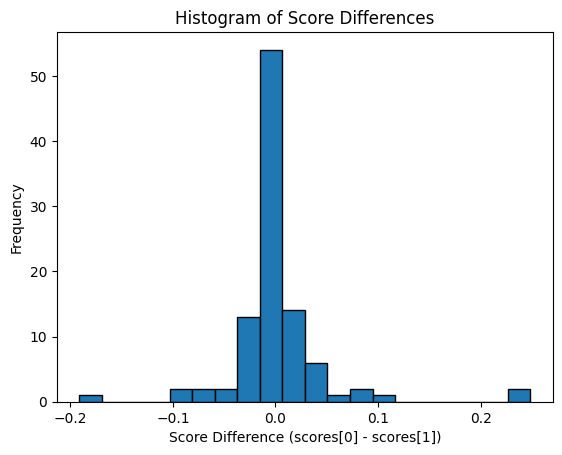

In [69]:
def plot_histogram():
    # Plot histogram
    plt.hist(score_differences, bins=20, edgecolor='black')  # Adjust bins as needed
    plt.xlabel('Score Difference (scores[0] - scores[1])')
    plt.ylabel('Frequency')
    plt.title('Histogram of Score Differences')
    plt.show()

plot_histogram()

In [72]:
def analyze(score_array, threshold = 0.05):
    total_scores = [0, 0]
    wins = [0, 0, 0]
    wins_above_threshold = [0, 0, 0]

    n = len(score_array)

    for i in range(n):
        score0 = score_array[i].scores[0]
        score1 = score_array[i].scores[1]
        diff = score0 - score1

        total_scores[0] += score0
        total_scores[1] += score1

        if diff > 0:
            wins[0] +=1
        elif diff < 0:
            wins[1] +=1
        else:
            wins[2] +=1

        if diff > threshold:
            wins_above_threshold[0] +=1
        elif diff < -threshold:
            wins_above_threshold[1] +=1
        else:
            wins_above_threshold[2] +=1

    average_scores = [total_scores[0]/n, total_scores[1]/n]
    print(average_scores)
    print(wins)
    print(wins_above_threshold)

analyze(loaded_evaluated_array, 0.05)

[0.928253937959671, 0.9259342342615128]
[43, 41, 16]
[6, 5, 89]
